## MSBD566 - Final Project
## Esmeralda Garcia
Data Source: https://www.kaggle.com/datasets/samiraalipour/genomics-of-drug-sensitivity-in-cancer-gdsc?resource=download&select=GDSC_DATASET.csv

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

pd.set_option("display.max_columns", 100)
plt.rcParams["figure.dpi"] = 120

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.11.0


In [9]:
df = pd.read_csv("GDSC_DATASET.csv")
print("Raw shape:", df.shape)
df.head()

LOW, HIGH = 0.0, np.log(10.0)

def label_ic50(x):
    if x < LOW:
        return "Very potent"
    elif x <= HIGH:
        return "Average sensitivity"
    else:
        return "Resistant"
        
df = df.dropna(subset=["LN_IC50"]).copy()
df["TargetClass"] = df["LN_IC50"].apply(label_ic50)

df["TargetClass"].value_counts()

Raw shape: (242035, 19)


TargetClass
Resistant              157188
Average sensitivity     51171
Very potent             33676
Name: count, dtype: int64

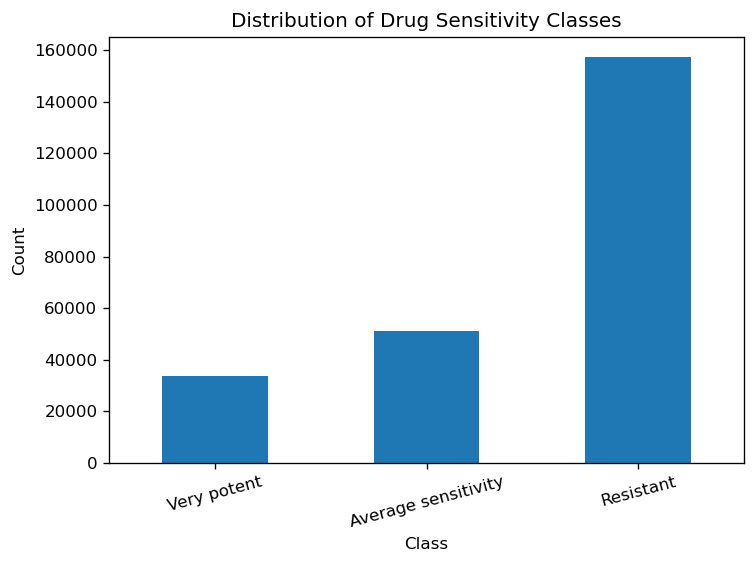

In [10]:
ax = df["TargetClass"].value_counts().reindex(
    ["Very potent","Average sensitivity","Resistant"]
).plot(kind="bar")
ax.set_title("Distribution of Drug Sensitivity Classes")
ax.set_xlabel("Class")
ax.set_ylabel("Count")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

In [5]:
X_num.dtypes

X_num.apply(lambda col: pd.to_numeric(col, errors="coerce")).isna().sum()

AUC                     0
Z_SCORE                 0
CNA                242035
Gene Expression    242035
Methylation        242035
dtype: int64

In [11]:
num_feats = [c for c in ["AUC", "Z_SCORE"] if c in df.columns]

cat_feats = [
    "GDSC Tissue descriptor 1",
    "TARGET_PATHWAY",
    "Microsatellite instability Status (MSI)",
    "Screen Medium",
    "Growth Properties",
    "CNA",
    "Gene Expression",
    "Methylation"
]

cat_feats = [c for c in cat_feats if c in df.columns]

print("Numeric features:", num_feats)
print("Categorical features:", cat_feats)

Numeric features: ['AUC', 'Z_SCORE']
Categorical features: ['GDSC Tissue descriptor 1', 'TARGET_PATHWAY', 'Microsatellite instability Status (MSI)', 'Screen Medium', 'Growth Properties', 'CNA', 'Gene Expression', 'Methylation']


In [12]:
X_num = df[num_feats].copy()
X_cat = df[cat_feats].copy()
y = df["TargetClass"].copy()

print("X_num shape:", X_num.shape)
print("X_cat shape:", X_cat.shape)
print("y shape:", y.shape)

X_num shape: (242035, 2)
X_cat shape: (242035, 8)
y shape: (242035,)


In [15]:
X_num_clean = X_num.apply(lambda col: pd.to_numeric(col, errors="coerce"))

num_imputer = SimpleImputer(strategy="median")
X_num_imputed = num_imputer.fit_transform(X_num_clean)

scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num_imputed)

print("Numeric scaled shape:", X_num_scaled.shape)

cat_imputer = SimpleImputer(strategy="most_frequent")
X_cat_imputed = cat_imputer.fit_transform(X_cat)


ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_cat_encoded = ohe.fit_transform(X_cat_imputed)

print("Categorical encoded shape:", X_cat_encoded.shape)

Numeric scaled shape: (242035, 2)
Categorical encoded shape: (242035, 56)


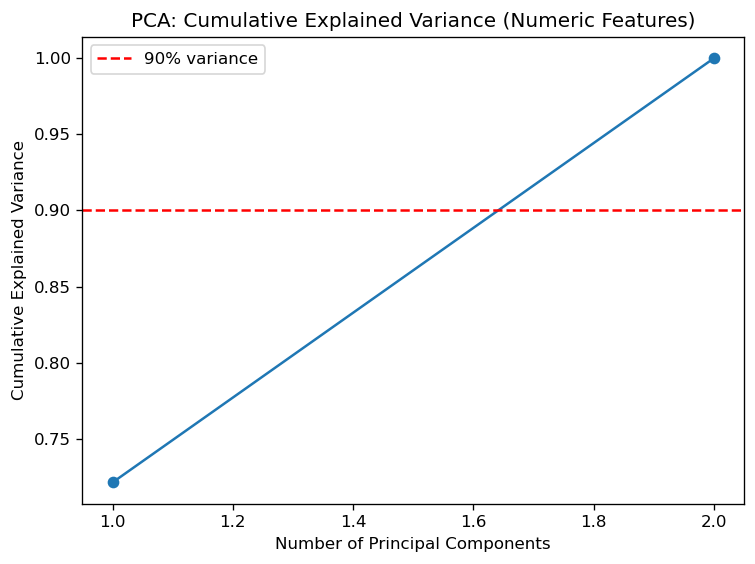

In [16]:
pca_full = PCA()
pca_full.fit(X_num_scaled)

explained_var_ratio = pca_full.explained_variance_ratio_
cum_explained = np.cumsum(explained_var_ratio)

plt.figure()
plt.plot(range(1, len(cum_explained)+1), cum_explained, marker="o")
plt.axhline(0.9, color="red", linestyle="--", label="90% variance")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA: Cumulative Explained Variance (Numeric Features)")
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
n_components = 2

pca = PCA(n_components=n_components)
X_num_pca = pca.fit_transform(X_num_scaled)

print("Original numeric shape:", X_num_scaled.shape)
print("After PCA numeric shape:", X_num_pca.shape)
print("Explained variance of chosen components:", pca.explained_variance_ratio_)
print("Total variance explained:", pca.explained_variance_ratio_.sum())

Original numeric shape: (242035, 2)
After PCA numeric shape: (242035, 2)
Explained variance of chosen components: [0.72129403 0.27870597]
Total variance explained: 1.0


In [18]:
X_all = np.hstack([X_num_pca, X_cat_encoded])
print("Final feature matrix shape:", X_all.shape)

Final feature matrix shape: (242035, 58)


In [19]:
X_train, X_test, y_train_text, y_test_text = train_test_split(
    X_all, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])
print("Train class counts:\n", y_train_text.value_counts())
print("\nTest class counts:\n", y_test_text.value_counts())

label_to_int = {"Very potent": 0, "Average sensitivity": 1, "Resistant": 2}
int_to_label = {v: k for k, v in label_to_int.items()}

y_train_int = y_train_text.map(label_to_int).values
y_test_int  = y_test_text.map(label_to_int).values

y_train_oh = to_categorical(y_train_int, num_classes=3)
y_test_oh  = to_categorical(y_test_int, num_classes=3)

print("y_train_int shape:", y_train_int.shape)
print("y_train_oh shape:", y_train_oh.shape)

Train size: 193628
Test size: 48407
Train class counts:
 TargetClass
Resistant              125750
Average sensitivity     40937
Very potent             26941
Name: count, dtype: int64

Test class counts:
 TargetClass
Resistant              31438
Average sensitivity    10234
Very potent             6735
Name: count, dtype: int64
y_train_int shape: (193628,)
y_train_oh shape: (193628, 3)


In [20]:
input_dim = X_train.shape[1]

model = Sequential([
    Dense(64, activation="relu", input_shape=(input_dim,)),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dropout(0.2),
    Dense(3, activation="softmax")
])

model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

model.summary()

history = model.fit(
    X_train, y_train_oh,
    validation_split=0.2,
    epochs=20,
    batch_size=256,
    verbose=1
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                3776      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 5,955
Trainable params: 5,955
Non-trainable params: 0
_________________________________________________________________


2025-12-07 23:59:43.533800: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-07 23:59:43.538504: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/20
606/606 [==============================] - 7s 10ms/step - loss: 0.4802 - accuracy: 0.8143 - val_loss: 0.3875 - val_accuracy: 0.8466
Epoch 2/20
606/606 [==============================] - 4s 6ms/step - loss: 0.4023 - accuracy: 0.8432 - val_loss: 0.3728 - val_accuracy: 0.8499
Epoch 3/20
606/606 [==============================] - 5s 8ms/step - loss: 0.3859 - accuracy: 0.8478 - val_loss: 0.3628 - val_accuracy: 0.8505
Epoch 4/20
606/606 [==============================] - 5s 8ms/step - loss: 0.3771 - accuracy: 0.8493 - val_loss: 0.3578 - val_accuracy: 0.8522
Epoch 5/20
606/606 [==============================] - 13s 21ms/step - loss: 0.3707 - accuracy: 0.8510 - val_loss: 0.3532 - val_accuracy: 0.8541
Epoch 6/20
606/606 [==============================] - 6s 10ms/step - loss: 0.3644 - accuracy: 0.8531 - val_loss: 0.3475 - val_accuracy: 0.8568
Epoch 7/20
606/606 [==============================] - 5s 9ms/step - loss: 0.3609 - accuracy: 0.8537 - val_loss: 0.3434 - val_accuracy: 0.8561
Ep

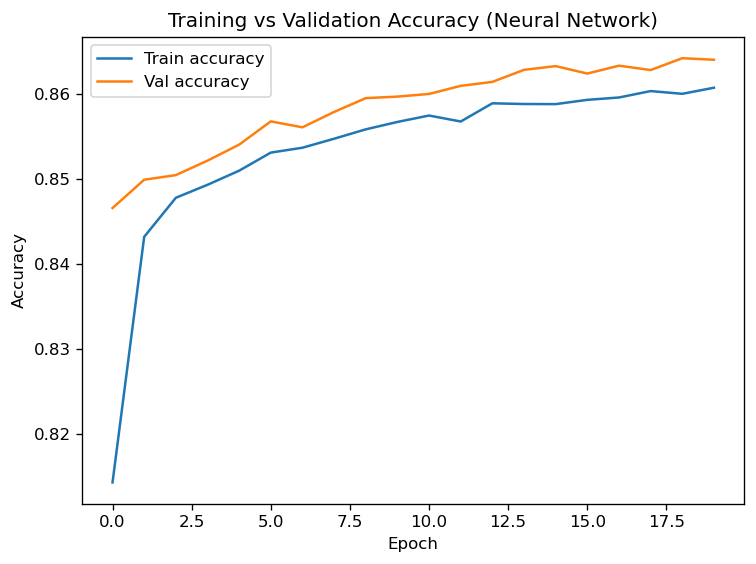

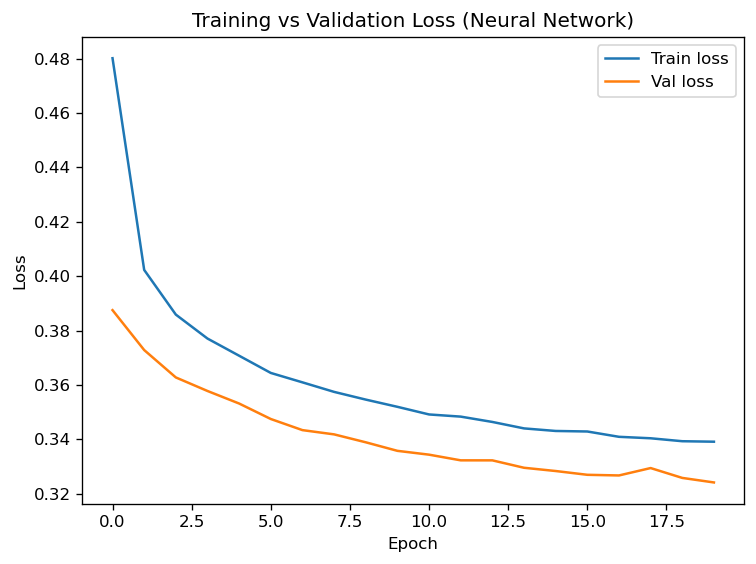

In [21]:
plt.figure()
plt.plot(history.history["accuracy"], label="Train accuracy")
plt.plot(history.history["val_accuracy"], label="Val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy (Neural Network)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(history.history["loss"], label="Train loss")
plt.plot(history.history["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (Neural Network)")
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
test_loss, test_acc = model.evaluate(X_test, y_test_oh, verbose=0)
print(f"Test accuracy: {test_acc:.3f}")
print(f"Test loss: {test_loss:.3f}")

y_pred_proba = model.predict(X_test)
y_pred_int = np.argmax(y_pred_proba, axis=1)
y_pred_labels = pd.Series(y_pred_int).map(int_to_label)

print("Classification report (Neural Network):")
print(classification_report(y_test_text, y_pred_labels, digits=3))

Test accuracy: 0.864
Test loss: 0.323
1513/1513 [==============================] - 10s 7ms/step
Classification report (Neural Network):
                     precision    recall  f1-score   support

Average sensitivity      0.744     0.672     0.706     10234
          Resistant      0.893     0.961     0.926     31438
        Very potent      0.891     0.705     0.788      6735

           accuracy                          0.864     48407
          macro avg      0.843     0.779     0.806     48407
       weighted avg      0.861     0.864     0.860     48407



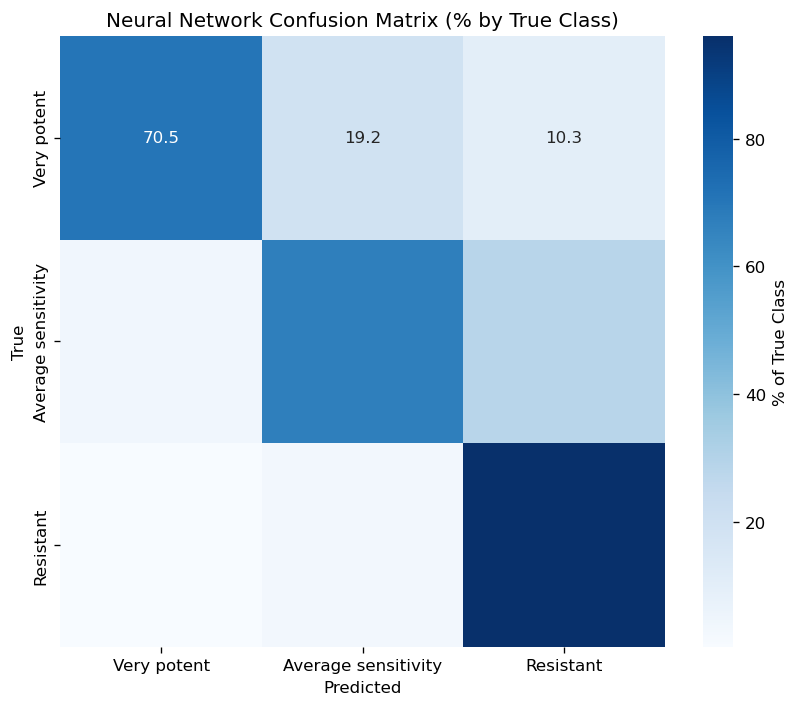

In [23]:
labels_order = ["Very potent","Average sensitivity","Resistant"]

cm = confusion_matrix(y_test_text, y_pred_labels, labels=labels_order)
cm_df = pd.DataFrame(cm, index=labels_order, columns=labels_order)
cm_perc = cm_df.div(cm_df.sum(axis=1), axis=0) * 100

plt.figure(figsize=(7,6))
sns.heatmap(cm_perc, annot=True, fmt=".1f", cmap="Blues",
            xticklabels=labels_order, yticklabels=labels_order,
            cbar_kws={'label': '% of True Class'})
plt.title("Neural Network Confusion Matrix (% by True Class)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()